## Accident Project code

In [99]:
import os
import string
import numpy as np
import sklearn
from scipy import sparse
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
import re
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from graphviz import Source
import graphviz
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from time import time
from scipy.linalg import svd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels
from sklearn.metrics import accuracy_score
import matplotlib as MIB
MIB.rcParams['figure.dpi'] = 300 #Setting figure crispness

## Loading data

In [100]:
df = pd.read_csv("US_Accidents_March23.csv", index_col="ID")

## Data cleaning section

In [101]:
# print data types
print(df.dtypes)

Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump                        bool
Crossing  

In [102]:
# # coerce data types, where necessary
# df["Start_Time"] = pd.to_datetime(df["Start_Time"])
# df["End_Time"] = pd.to_datetime(df["End_Time"])

In [103]:
# drop columns with only one unique value
df = df.drop(columns=["Country", "Turning_Loop"])

In [104]:
# investigate normal ranges
def iqr_rule(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    large_outliers = (col < q1 - 1.5 * (q3 - q1))
    small_outliers = (col > q3 + 1.5 * (q3 - q1))
    return (large_outliers + small_outliers).mean()

numeric_columns = ["Precipitation(in)", "Wind_Speed(mph)", "Visibility(mi)", "Pressure(in)", "Humidity(%)", "Wind_Chill(F)", "Temperature(F)", "Distance(mi)", "End_Lng", "End_Lat", "Start_Lng", "Start_Lat"]

outliers = pd.DataFrame(
    index=[col for col in df[numeric_columns]],
    data={
        "min_value": df[numeric_columns].min(axis=0),
        "max_value": df[numeric_columns].max(axis=0),
        "outlier_percent": [iqr_rule(df[col]) for col in df[numeric_columns]]
    }
)
print(outliers)

                    min_value    max_value  outlier_percent
Precipitation(in)    0.000000    36.470000         0.068978
Wind_Speed(mph)      0.000000  1087.000000         0.027251
Visibility(mi)       0.000000   140.000000         0.191639
Pressure(in)         0.000000    58.630000         0.057371
Humidity(%)          1.000000   100.000000         0.000000
Wind_Chill(F)      -89.000000   207.000000         0.005676
Temperature(F)     -89.000000   207.000000         0.006536
Distance(mi)         0.000000   441.750000         0.124684
End_Lng           -124.545748   -67.109242         0.000000
End_Lat             24.566013    49.075000         0.000000
Start_Lng         -124.623833   -67.113167         0.000000
Start_Lat           24.554800    49.002201         0.000000


In [105]:
# drop numerical outliers
num_rows = len(df)
df = df[df["Wind_Speed(mph)"] <= 231] # fastest recorded wind speed in the western hemisphere
df = df[(df["Pressure(in)"] >= 26) & (df["Pressure(in)"] <= 32)] # see paper citations
df = df[(df["Wind_Chill(F)"] >= -80) & (df["Wind_Chill(F)"] <= 134)] # see paper citations
df = df[(df["Temperature(F)"] >= -80) & (df["Temperature(F)"] <= 134)] # see paper citations
df = df[df["Distance(mi)"] <= 20] # this cutoff was tougher, this excludes about 0.1% of the data (440 miles is too long)
print("# of Rows Dropped: ", num_rows - len(df))

# of Rows Dropped:  2206931


In [106]:
# Search for Potential Weird Values
for col in df:
    print("Column Name: ", col)
    print("Unique Values: ", df[col].unique())
    print("--------------")

Column Name:  Source
Unique Values:  ['Source2' 'Source3' 'Source1']
--------------
Column Name:  Severity
Unique Values:  [2 3 1 4]
--------------
Column Name:  Start_Time
Unique Values:  ['2016-02-08 06:49:27' '2016-02-08 07:23:34' '2016-02-08 07:39:07' ...
 '2019-08-23 19:11:30' '2019-08-23 19:00:21' '2019-08-23 18:52:06']
--------------
Column Name:  End_Time
Unique Values:  ['2016-02-08 07:19:27' '2016-02-08 07:53:34' '2016-02-08 08:09:07' ...
 '2019-08-23 19:28:49' '2019-08-23 19:29:42' '2019-08-23 19:21:31']
--------------
Column Name:  Start_Lat
Unique Values:  [39.063148 39.747753 39.627781 ... 34.26103  33.7417   34.239104]
--------------
Column Name:  Start_Lng
Unique Values:  [ -84.032608  -84.205582  -84.188354 ... -118.416176 -117.14806
 -117.84779 ]
--------------
Column Name:  End_Lat
Unique Values:  [      nan 40.11206  39.170476 ... 34.239104 32.76555  33.98311 ]
--------------
Column Name:  End_Lng
Unique Values:  [        nan  -83.03187   -84.501798 ... -117.15363  

In [107]:
# limit dataset size if desired in order to decrease computation time
# SAMPLE_RATIO = 15_000 / len(df)
SAMPLE_RATIO = 1.0
df = df.sample(frac=SAMPLE_RATIO, random_state=40)

In [108]:
# drop other columns we exclude for various reasons
df = df.drop(columns=[
    "Source",
    "Description",
    #"Street",
    "City",
    "County",
    "State",
    "Zipcode",
    "Airport_Code",
    "Weather_Timestamp",
    "Wind_Direction",
    #"Weather_Condition",
    "Sunrise_Sunset",
    "Civil_Twilight",
    "Nautical_Twilight",
    "Astronomical_Twilight"
])

In [109]:
#Building simple modifier to account for type of road, a possibly big factor in severity
XNames = []
for i in range(len(df["Street"])):
    if "I-" in str(df["Street"][i]) or "Interstate"in str(df["Street"][i]) or "Freeway"in str(df["Street"][i]) or "Fwy"in str(df["Street"][i]) or "Route"in str(df["Street"][i]):
        XNames.append(1)
    else:
        XNames.append(0)
df["StreetInt"] = XNames

/var/folders/9f/s57r9t7d0mq0pmklmjxgnzx40000gn/T/ipykernel_95866/1772652773.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if "I-" in str(df["Street"][i]) or "Interstate"in str(df["Street"][i]) or "Freeway"in str(df["Street"][i]) or "Fwy"in str(df["Street"][i]) or "Route"in str(df["Street"][i]):


In [110]:
# train test split
df = pd.get_dummies(df,columns=["Weather_Condition",])
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Severity"), df["Severity"], test_size=0.15, random_state = 30)

In [111]:
print(len(y_train))

4693243


In [112]:
# Missing Values
missing = pd.DataFrame(
    index=[col for col in df if df[col].isna().any()],
    data={"Missing Data (%)": [100 * df[col].isna().sum() / len(df) for col in df if df[col].isna().any()]},
)
print(missing)

                   Missing Data (%)
End_Lat                   34.027123
End_Lng                   34.027123
Street                     0.178920
Humidity(%)                0.146519
Visibility(mi)             0.312924
Precipitation(in)          8.082387


In [113]:
# drop columns with large proportions of missing data
X_train = X_train.drop(columns=["End_Lat", "End_Lng", "Street"])
X_test = X_test.drop(columns=["End_Lat", "End_Lng", "Street"])
y_train = y_train.drop(columns=["End_Lat", "End_Lng", "Street"])
y_test = y_test.drop(columns=["End_Lat", "End_Lng", "Street"])

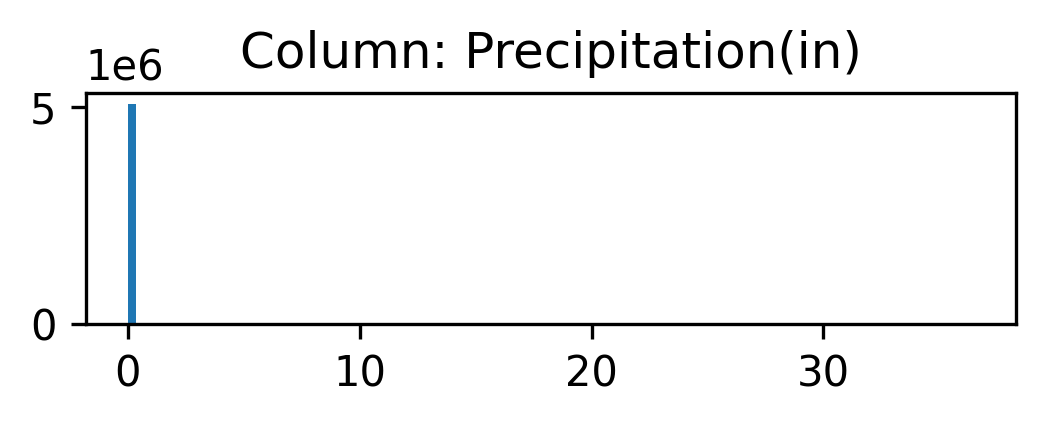

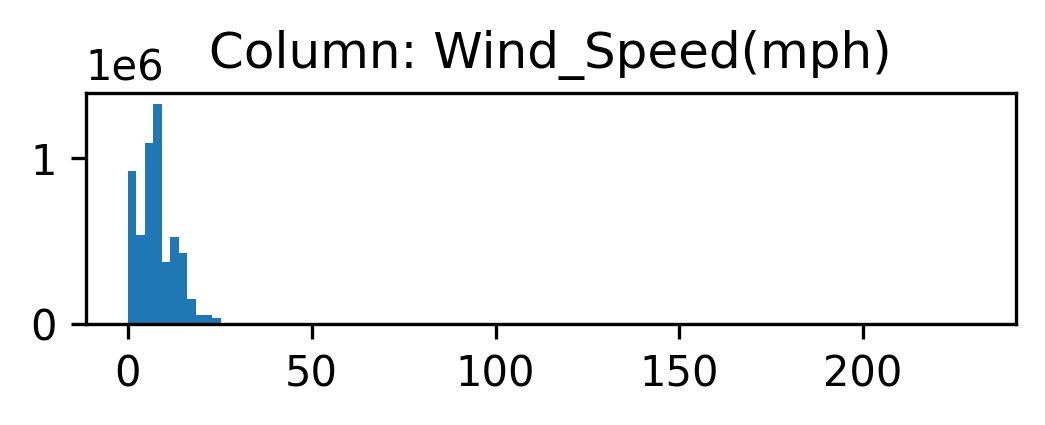

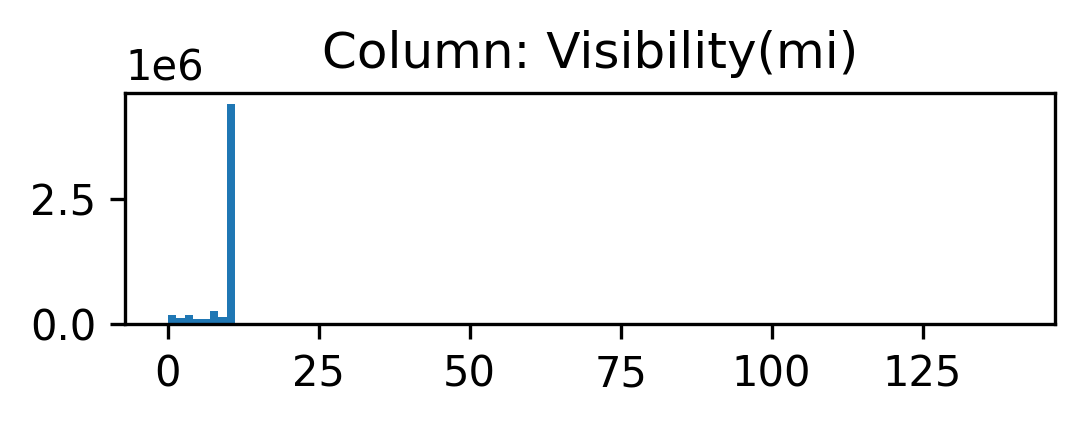

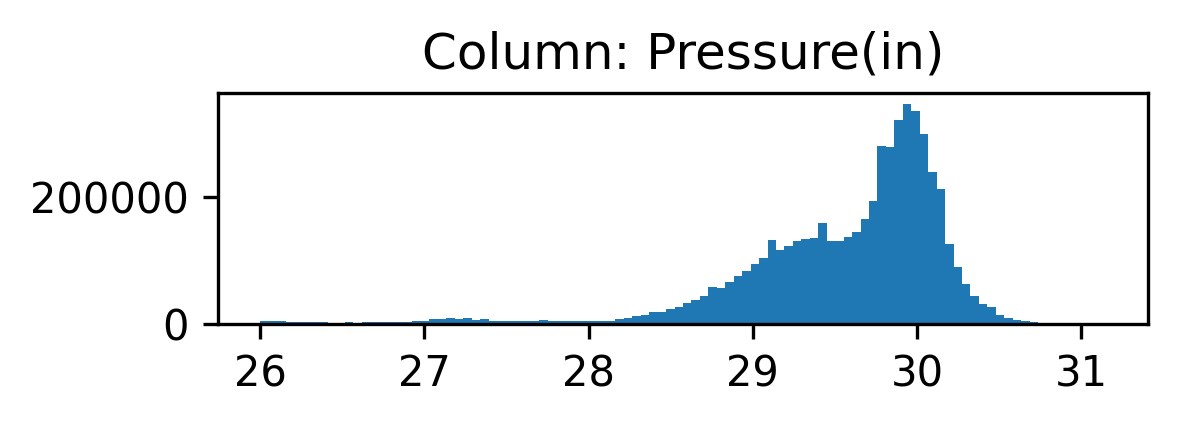

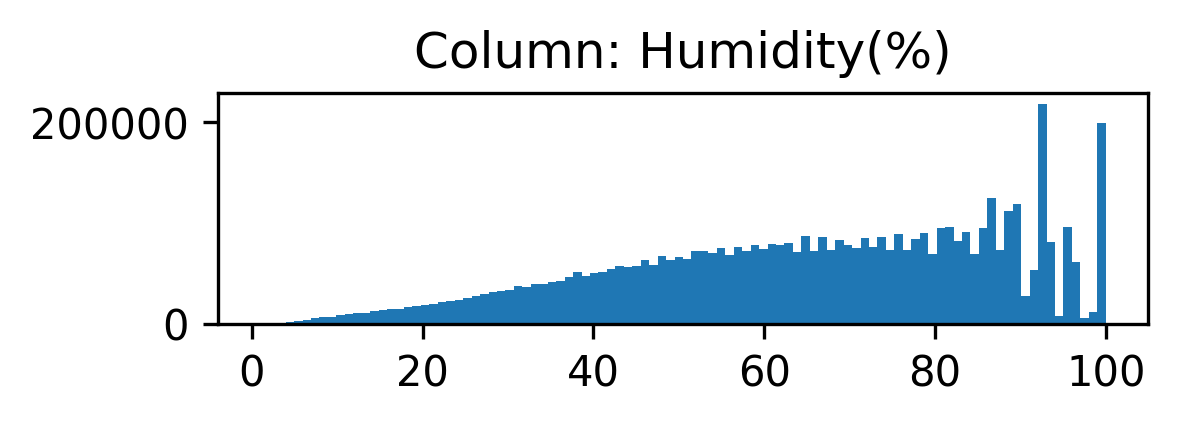

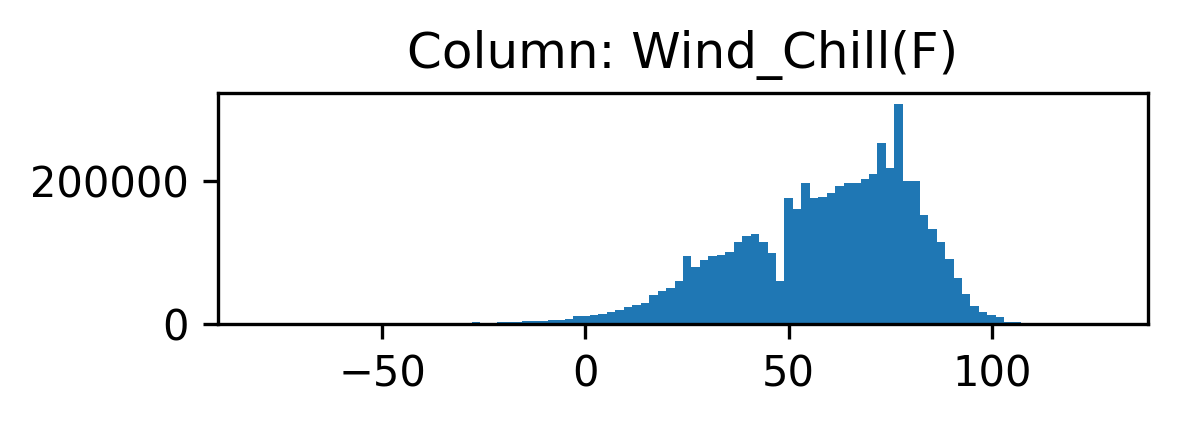

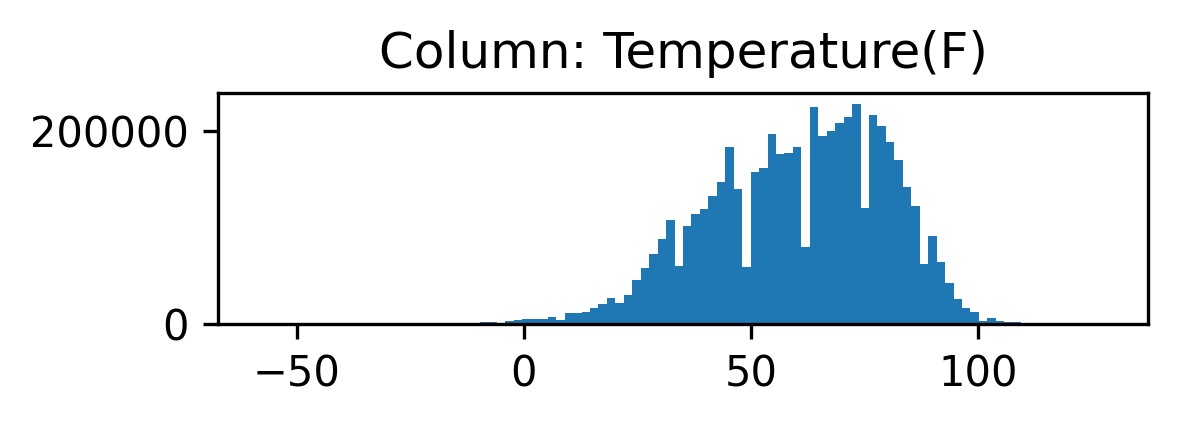

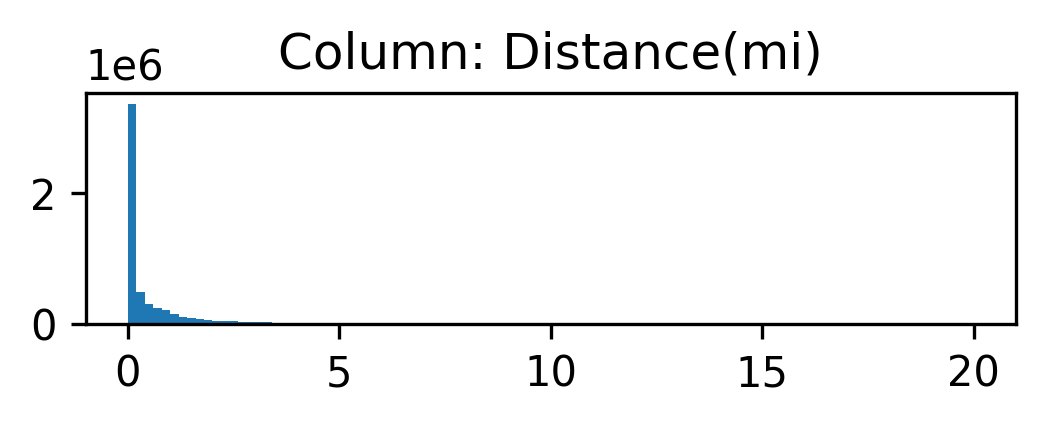

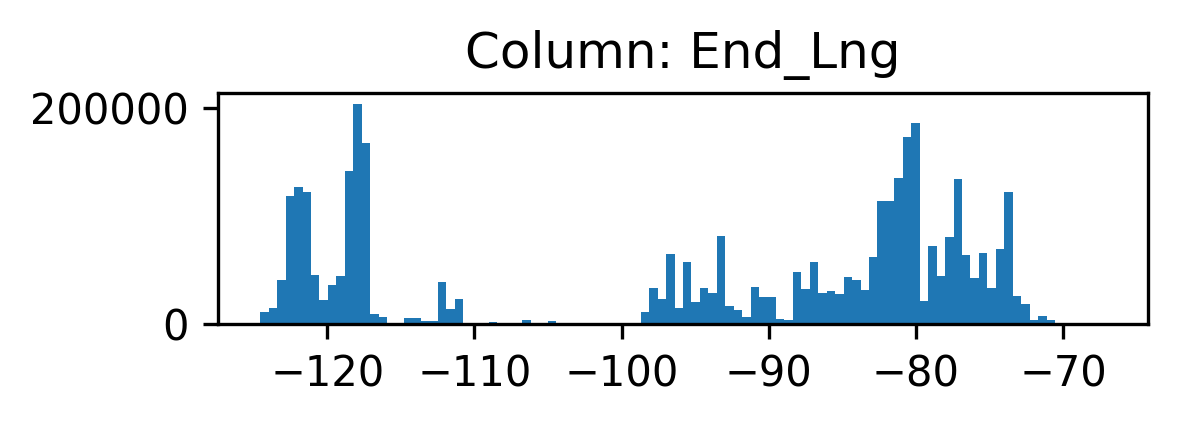

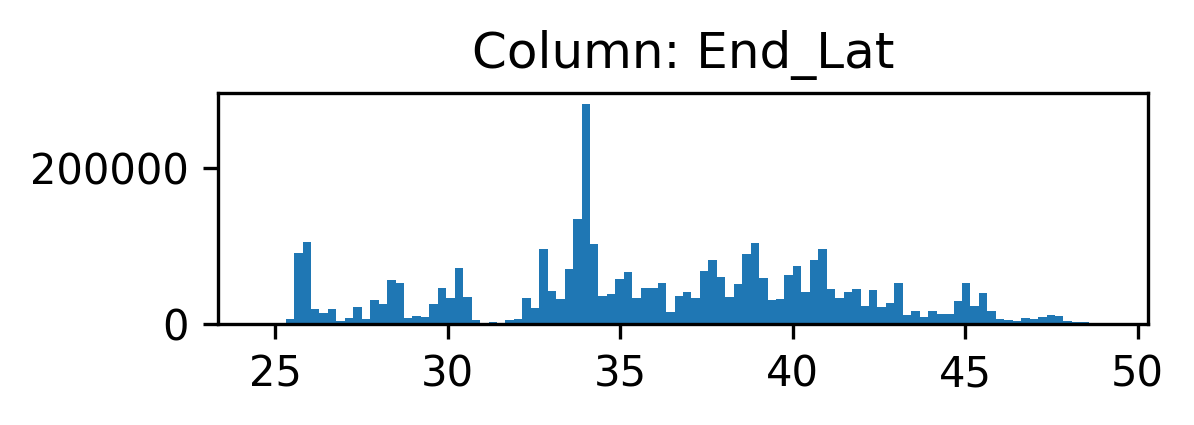

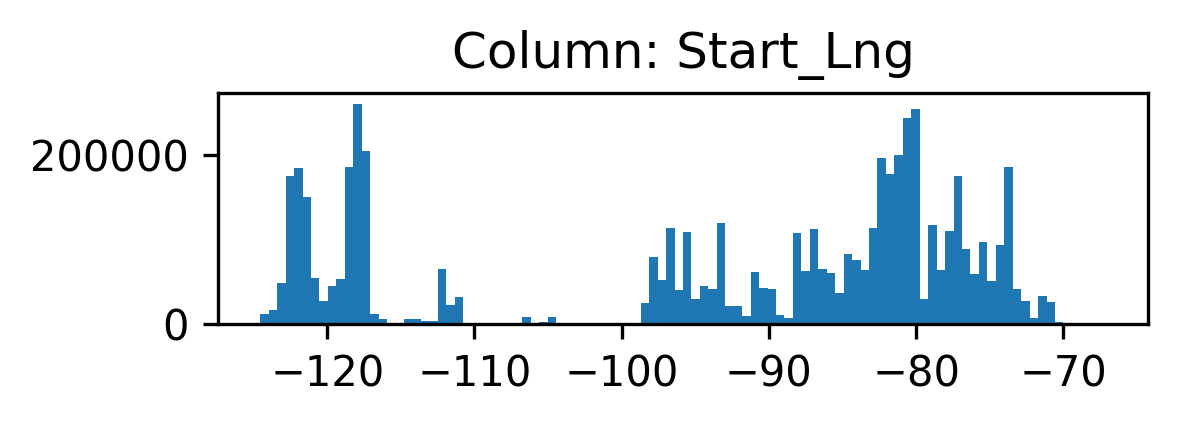

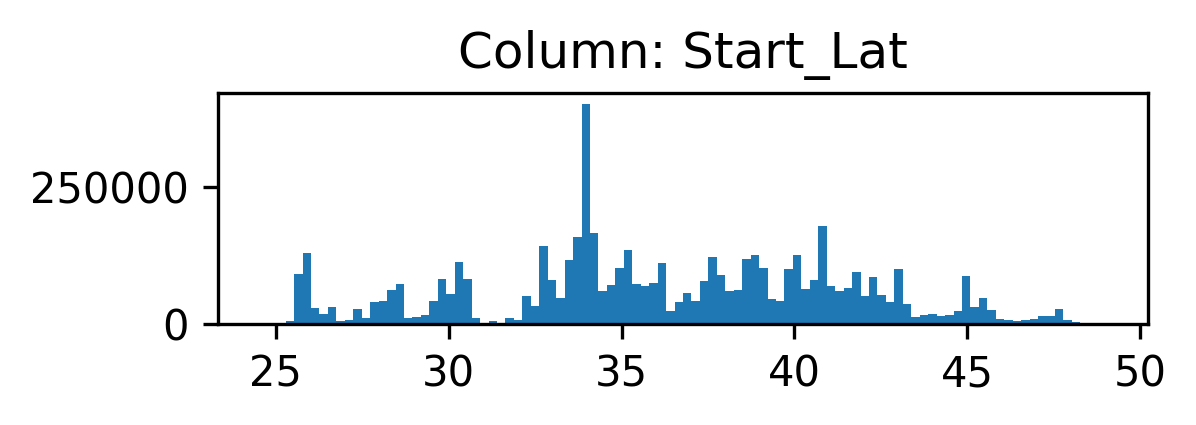

In [114]:
# plot histograms of each numeric column to determine whether to apply mean or median imputation (median seems reasonable for most)
numeric_columns = ["Precipitation(in)", "Wind_Speed(mph)", "Visibility(mi)", "Pressure(in)", "Humidity(%)", "Wind_Chill(F)", "Temperature(F)", "Distance(mi)", "End_Lng", "End_Lat", "Start_Lng", "Start_Lat"]


for col in df[numeric_columns]:
    fig = plt.figure(figsize=(4, 1))
    ax = fig.add_subplot(111)
    ax.hist(df[col], bins=100)
    ax.set_title(f"Column: {col}")
    plt.show()

In [115]:
# data imputation
need_imputation = ["Humidity(%)", "Visibility(mi)", "Precipitation(in)"]

imputation_strategy = {
    "Humidity(%)": "median",
    "Visibility(mi)": "median",
    "Precipitation(in)": "median",
}

for col in need_imputation:
    imputer = SimpleImputer(strategy=imputation_strategy[col])
    X_train[col] = imputer.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = imputer.transform(X_test[col].values.reshape(-1, 1))

In [116]:
# save data files
VERSION=1
X_train.to_csv(f"X_train_v{VERSION}")
X_test.to_csv(f"X_test_v{VERSION}")
y_train.to_csv(f"y_train_v{VERSION}")
y_test.to_csv(f"y_test_v{VERSION}")

## Training and comparing algorithms

In [117]:
X_train = X_train.drop(columns=["Start_Time", "End_Time", "Timezone"])
X_test = X_test.drop(columns=["Start_Time", "End_Time", "Timezone"])

In [118]:
#Fixing smaller training size
X_train = X_train.iloc[:15000]
y_train = y_train.iloc[:15000]

In [119]:
#Building gridsearches for Kneighbors, randomforest, decisiontree, and GradientBoosting respectively
#to find ideal parameters for the next part
param_grid = {"weights": ['uniform', 'distance'], "leaf_size": [15, 20, 30, 35], "n_neighbors" : [3, 4, 5, 6, 7]}
K = KNeighborsClassifier()
K_gs = GridSearchCV(K, param_grid)
K_gs.fit(X_train, y_train)
K_params = K_gs.best_params_

param_grid = {"max_features": ['sqrt', 'log2'], "max_depth": [2, 3, 4, 5, 6], "n_estimators" : [50, 75, 100, 150, 200]}
forest = RandomForestClassifier(warm_start=False)
forest_gs = GridSearchCV(forest, param_grid, n_jobs=-1)
forest_gs.fit(X_train, y_train)
forest_params = forest_gs.best_params_


param_grid = {"criterion": ['gini', 'entropy', 'log_loss'], "max_depth": [2, 3, 4, 5, 6], "min_samples_split": [2, 4, 8, 16], "min_samples_leaf": [1,3,4], "max_features": ['sqrt', 'log2']}
D = DecisionTreeClassifier()
D_gs = GridSearchCV(D, param_grid, n_jobs=-1)
D_gs.fit(X_train, y_train)
D_params = D_gs.best_params_

param_grid = {"max_features": ['sqrt', 'log2'], "max_depth": [2, 4, 8,16], "n_estimators" : [75,100,150,200,250]}
Grad = GradientBoostingClassifier()
Grad_gs = GridSearchCV(Grad, param_grid, n_jobs=-1)
Grad_gs.fit(X_train, y_train)
G_params = Grad_gs.best_params_

KeyboardInterrupt: 

In [120]:
#Printing out ideal parameters
print(K_params)
print(forest_params)
print(G_params)
print(D_params)

{'leaf_size': 15, 'n_neighbors': 6, 'weights': 'uniform'}
{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 50}
{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
{'criterion': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 16}


In [121]:
#This block of code takes the best parameters determined above
#and trains models of increasing size to produce the accuracy plot
Glist = []
Dlist = []
Flist = []
Klist = []
ControlList = []
N = np.linspace(1000,15000,15)
for n in N:
    print(n)
    X_tr = X_train.iloc[:int(n)]
    y_tr = y_train.iloc[:int(n)]
    G = GradientBoostingClassifier(max_depth = 8, max_features = 'sqrt', n_estimators = 100)
    forest = RandomForestClassifier(max_depth = 2, max_features = 'sqrt', n_estimators = 50,warm_start=False)
    D = DecisionTreeClassifier(criterion = 'log_loss', max_depth = 3, max_features = 'sqrt', min_samples_leaf = 3, min_samples_split = 16)
    K = KNeighborsClassifier(leaf_size = 15, n_neighbors = 6, weights = 'uniform')
    G.fit(X_tr,y_tr)
    D.fit(X_tr,y_tr)
    forest.fit(X_tr,y_tr)
    K.fit(X_tr,y_tr)
    forest_pred = forest.predict(X_test)
    G_pred = G.predict(X_test)
    K_pred = K.predict(X_test)
    D_pred = D.predict(X_test)
    ControlList.append(accuracy_score(y_test, np.ones_like(y_test)*2))
    Flist.append(accuracy_score(y_test, forest_pred))
    Dlist.append(accuracy_score(y_test, D_pred))
    Klist.append(accuracy_score(y_test, K_pred))
    Glist.append(accuracy_score(y_test, G_pred))

1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0
11000.0
12000.0
13000.0
14000.0
15000.0


Text(0, 0.5, 'Accuracy')

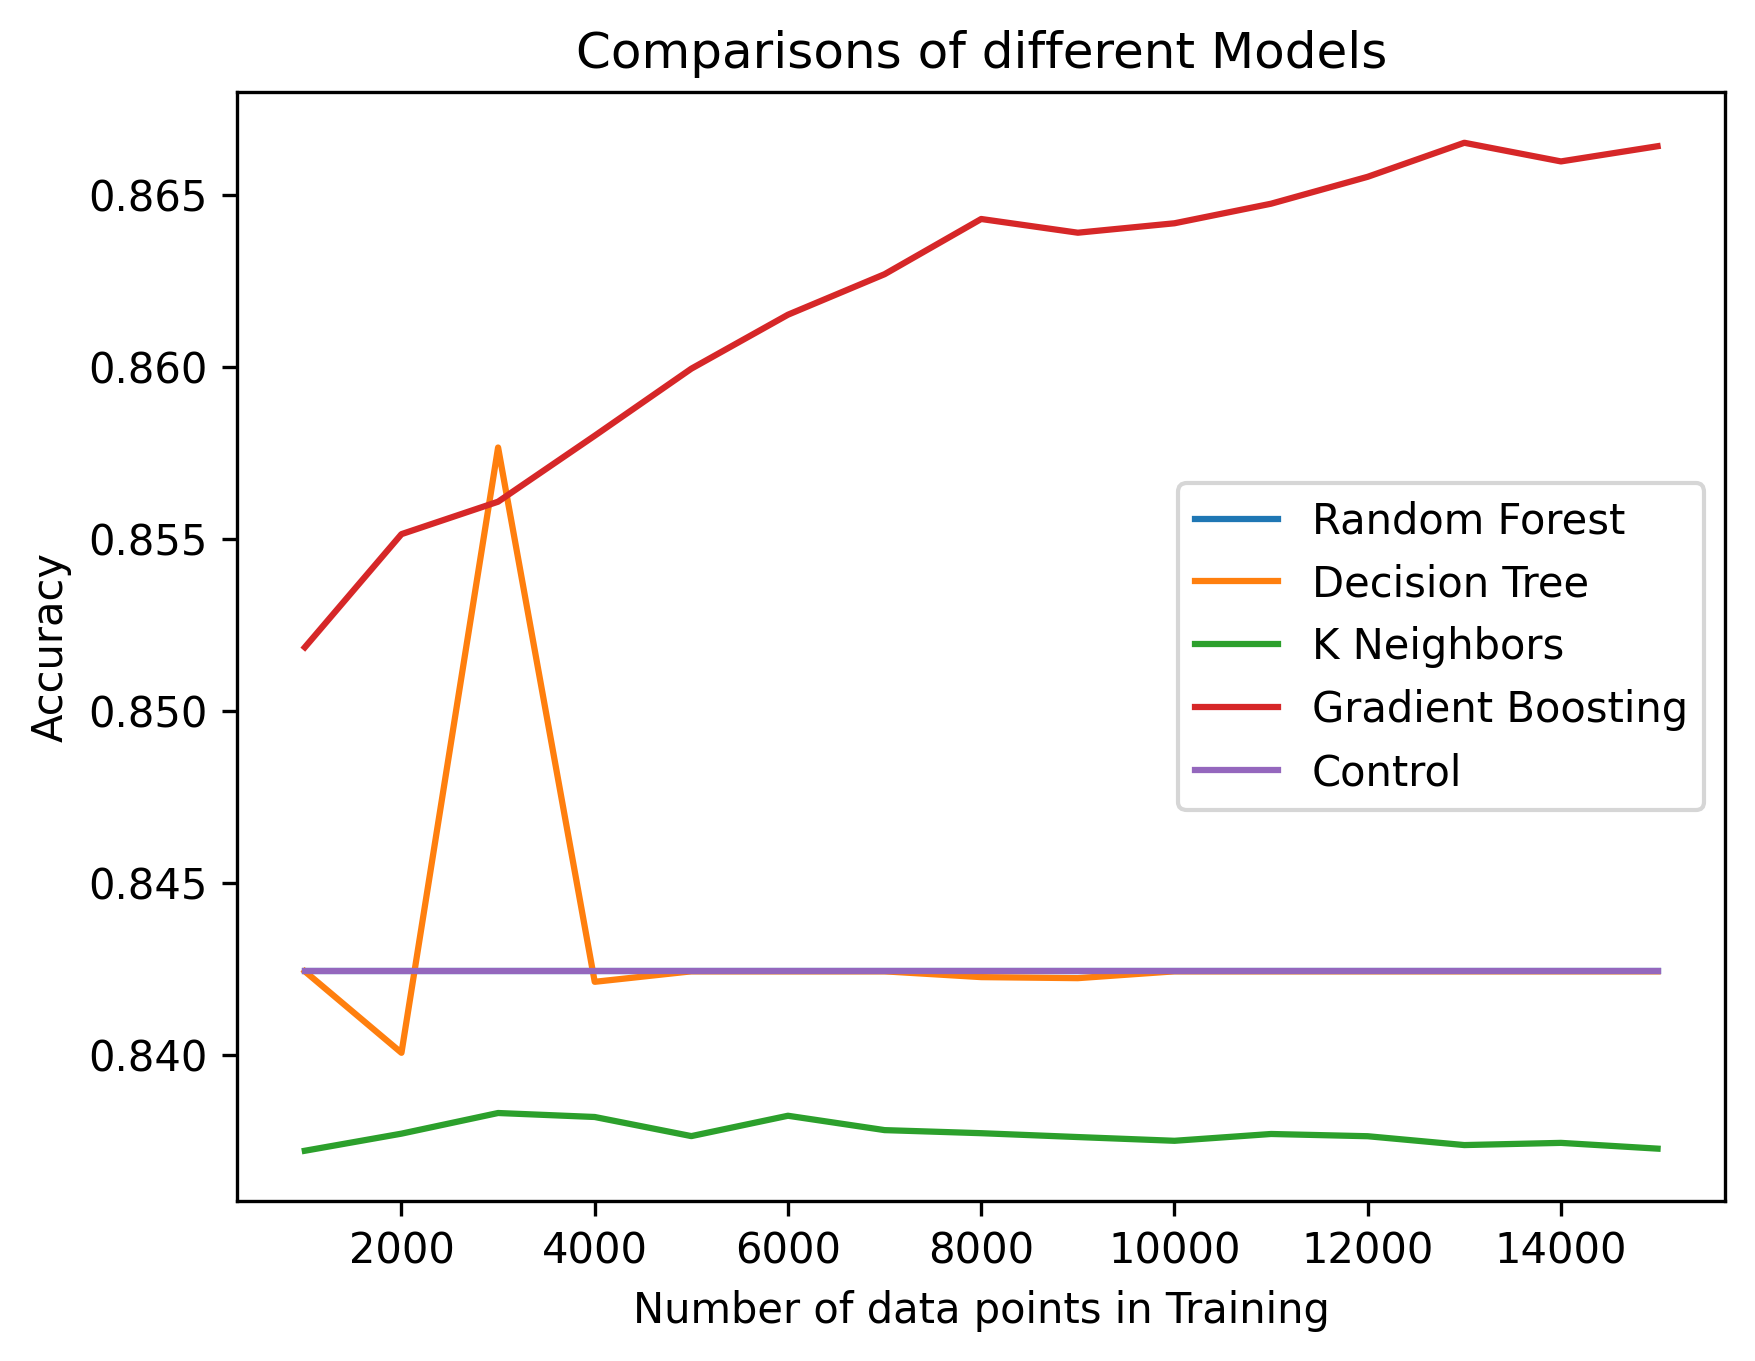

In [122]:
plt.plot(N, Flist, label = "Random Forest")
plt.plot(N, Dlist, label = "Decision Tree")
plt.plot(N, Klist, label = "K Neighbors")
plt.plot(N, Glist, label = "Gradient Boosting")
plt.plot(N,ControlList, label = "Control")
plt.legend()
plt.title("Comparisons of different Models")
plt.xlabel("Number of data points in Training")
plt.ylabel("Accuracy")

## Testing impact of having a majority rows be severity 2

In [123]:
df_Sep = df.copy()
df_Sep1 = df_Sep.loc[df["Severity"] == 1]
df_Sep4 = df_Sep.loc[df["Severity"] == 4]
df_Sep3 = df_Sep.loc[df["Severity"] == 3].sample(len(df_Sep4["Severity"]), random_state=34)
df_Sep2 = df_Sep.loc[df["Severity"] == 2].sample(len(df_Sep4["Severity"]), random_state=34)
frames = [df_Sep1,df_Sep2,df_Sep3,df_Sep4]

df_final = pd.concat(frames)

X_train2, X_test2, y_train2, y_test2 = train_test_split(df_final.drop(columns="Severity"), df_final["Severity"], test_size=0.15, random_state = 30)

In [124]:
X_train2 = X_train2.drop(columns=["Start_Time", "End_Time", "Timezone","End_Lat", "End_Lng","Street"])
X_test2 = X_test2.drop(columns=["Start_Time", "End_Time", "Timezone","End_Lat", "End_Lng","Street"])

In [125]:
# data imputation
need_imputation = ["Humidity(%)", "Visibility(mi)", "Precipitation(in)"]

imputation_strategy = {
    "Humidity(%)": "median",
    "Visibility(mi)": "median",
    "Precipitation(in)": "median",
}

for col in need_imputation:
    imputer = SimpleImputer(strategy=imputation_strategy[col])
    X_train2[col] = imputer.fit_transform(X_train2[col].values.reshape(-1, 1))
    X_test2[col] = imputer.transform(X_test2[col].values.reshape(-1, 1))

In [126]:
#This block of code takes the best parameters determined above
#and trains models of increasing size to produce the accuracy plot
G2list = []
D2list = []
F2list = []
K2list = []
# ControlList = []
N = np.linspace(1000,15000,15)
for n in N:
    print(n)
    X_tr2 = X_train2.iloc[:int(n)]
    y_tr2 = y_train2.iloc[:int(n)]
    G = GradientBoostingClassifier(max_depth = 8, max_features = 'sqrt', n_estimators = 100)
    forest = RandomForestClassifier(max_depth = 2, max_features = 'sqrt', n_estimators = 50,warm_start=False)
    D = DecisionTreeClassifier(criterion = 'log_loss', max_depth = 3, max_features = 'sqrt', min_samples_leaf = 3, min_samples_split = 16)
    K = KNeighborsClassifier(leaf_size = 15, n_neighbors = 6, weights = 'uniform')
    G.fit(X_tr2,y_tr2)
    D.fit(X_tr2,y_tr2)
    forest.fit(X_tr2,y_tr2)
    K.fit(X_tr2,y_tr2)
    forest_pred = forest.predict(X_test2)
    G_pred = G.predict(X_test2)
    K_pred = K.predict(X_test2)
    D_pred = D.predict(X_test2)
    #ControlList.append(accuracy_score(y_test, np.ones_like(y_test)*2))
    F2list.append(accuracy_score(y_test2, forest_pred))
    D2list.append(accuracy_score(y_test2, D_pred))
    K2list.append(accuracy_score(y_test2, K_pred))
    G2list.append(accuracy_score(y_test2, G_pred))

1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0
11000.0
12000.0
13000.0
14000.0
15000.0


Text(0, 0.5, 'Accuracy')

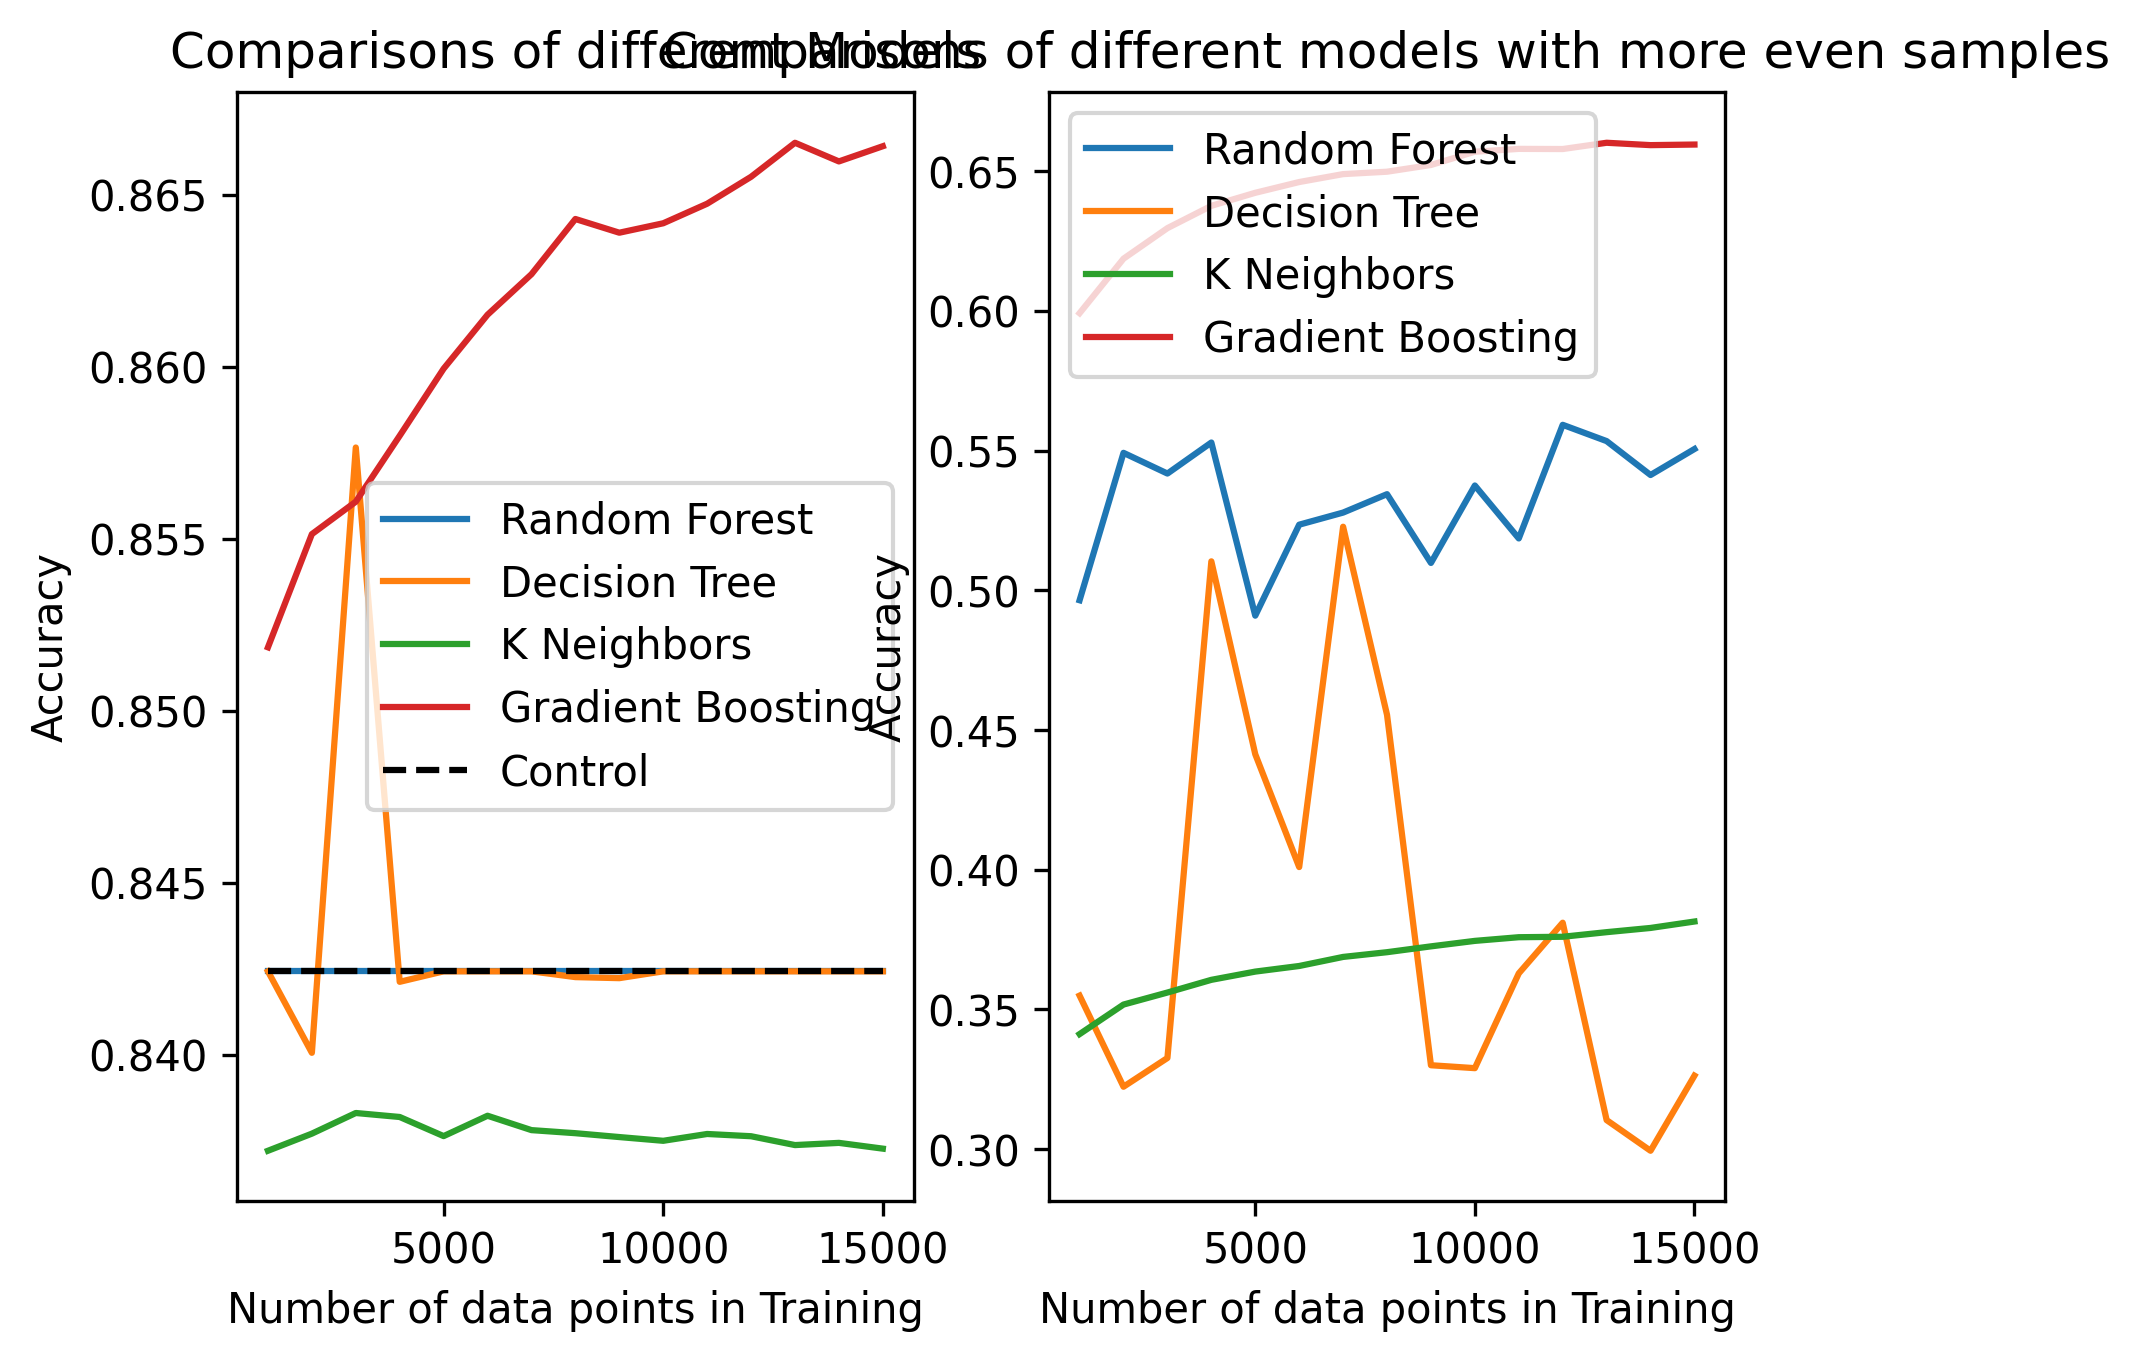

In [127]:
plt.subplot(1,2,1)
plt.plot(N, Flist, label = "Random Forest")
plt.plot(N, Dlist, label = "Decision Tree")
plt.plot(N, Klist, label = "K Neighbors")
plt.plot(N, Glist, label = "Gradient Boosting")
plt.plot(N,ControlList,"k--", label = "Control")
plt.legend()
plt.title("Comparisons of different Models")
plt.xlabel("Number of data points in Training")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(N, F2list, label = "Random Forest")
plt.plot(N, D2list, label = "Decision Tree")
plt.plot(N, K2list, label = "K Neighbors")
plt.plot(N, G2list, label = "Gradient Boosting")
#plt.plot(N,ControlList, label = "Control")
plt.legend(loc = "upper left")
plt.title("Comparisons of different models with more even samples")
plt.xlabel("Number of data points in Training")
plt.ylabel("Accuracy")

In [129]:
df_Sep1 = df_Sep.loc[df["Severity"] == 1]
df_Sep4 = df_Sep.loc[df["Severity"] == 4]
df_Sep3 = df_Sep.loc[df["Severity"] == 3]
df_Sep2 = df_Sep.loc[df["Severity"] == 2]
print("1, ", len(df_Sep1))
print("2, ", len(df_Sep2))
print("3, ", len(df_Sep3))
print("4, ", len(df_Sep4))

1,  62927
2,  4652614
3,  669437
4,  136485
